Import libraries:

In [1]:
import praw
import pandas as pd
import re
import requests
import math
import numpy as np
import sklearn
import datetime

import mplfinance as mpf
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

Reddit API:

In [2]:
reddit = praw.Reddit(client_id='cuZMOjeHBSEsEQ', client_secret='-yAaFZL159o722jCqmy6KkJT_VzDag', user_agent='Stock Scraping')

# Getting top stock / crypto tickers:

In [3]:
def get_top_posts_stocks(subr):
    df = []
    
    # Gather top posts from subreddit (title and text only)
    for post in reddit.subreddit(subr).hot(limit=200):
        content = {
            "title": post.title,
            "text": post.selftext
        }
        df.append(content)
    df = pd.DataFrame(df)
    
    # Regular expression for stock tickers
    regex = re.compile('[^a-zA-Z ]')
    word_dict = {}
    for (index, row) in df.iterrows():
      # Titles
      title = row['title']
      title = regex.sub('', title)
      title_words = title.split(' ')
      # Content
      content = row['text']
      content = regex.sub('', content)
      content_words = content.split(' ')
      # Combine
      words = title_words + content_words
      for x in words:
        if x in ['A', 'B', 'GO', 'ARE', 'ON']:
          pass
    
        elif x in word_dict:
          word_dict[x] += 1
        else:
          word_dict[x] = 1
    
    # Define our data as global so we can access it outside of the function
    global word_df, ticker_df, stonks_df, currencies_df, crypto_df
    
    # Various datasets we're joining on
    word_df = pd.DataFrame.from_dict(list(word_dict.items())).rename(columns = {0:"Symbol", 1:"Frequency"})
    
    ticker_df = pd.read_csv("tickers.csv").rename(columns = {"Symbol":"Symbol", "Name":"Company Name"})
    
    currencies_df = pd.read_csv("Coinbase Currencies.csv")
    
    stonks_df = pd.merge(ticker_df, word_df, on="Symbol")
    
    crypto_df = pd.merge(currencies_df, word_df, on= "Symbol")

**Stocks example:**

In [4]:
get_top_posts_stocks("WallStreetBets")
stonks_df.sort_values("Frequency", ascending= False).head(10)

,Symbol,Company Name,Frequency
167,WISH,ContextLogic Inc. Class A Common Stock,61
29,CLNE,Clean Energy Fuels Corp. Common Stock,56
39,DD,DuPont de Nemours Inc. Common Stock,52
114,PLTR,Palantir Technologies Inc. Class A Common Stock,51
34,CRSR,Corsair Gaming Inc. Common Stock,44
5,AMC,AMC Entertainment Holdings Inc. Class A Common...,34
91,M,Macy's Inc Common Stock,34
169,WOOF,Petco Health and Wellness Company Inc. Class A...,25
127,RNG,RingCentral Inc. Class A Common Stock,22
17,BGS,B&G Foods Inc. B&G Foods Inc. Common Stock,22


**Crypto Example:**

In [5]:
get_top_posts_stocks("CryptoMarkets")
crypto_df.sort_values("Frequency", ascending= False).head(10)

,Symbol,Name,Frequency
4,ETH,Ethereum,16
2,BTC,Bitcoin,10
0,ADA,Cardano,5
3,DAI,Dai,4
7,XRP,XRP,4
5,LINK,ChainLink,2
6,NU,NuCypher,2
1,ATOM,Atomic Coin,1
8,ZEC,Zcash,1


# Candlestick Visualization:

Candlestick visualization for STOCKS:

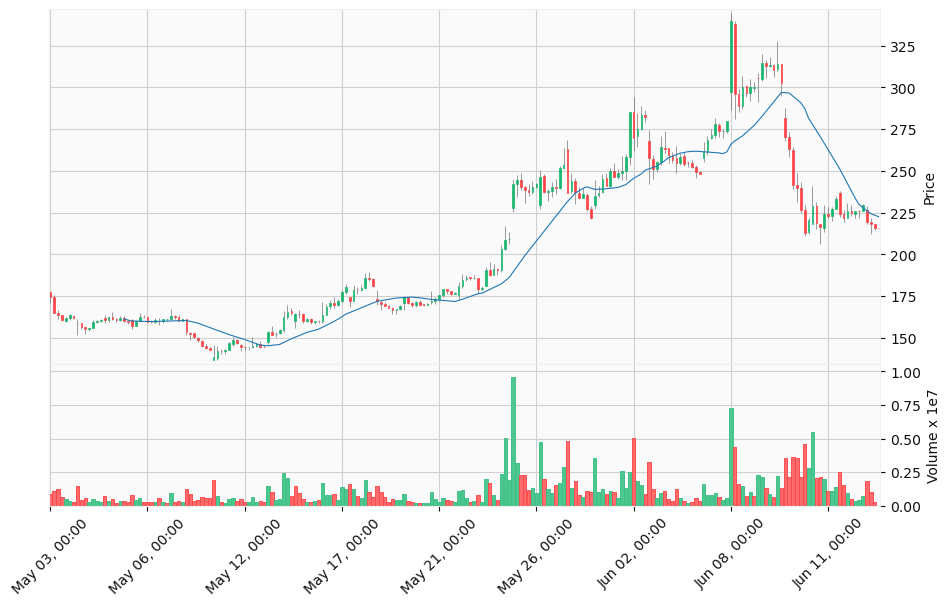

In [6]:
# Can check stocks here that you find interesting

# Insert ticker here
ticker = yf.Ticker("GME")

hist_stock = ticker.history(period = "1y", interval = "1h")

# Change timeline here
mpf.plot(hist_stock["2021-05-01":"2021-06-15"],
         volume = True, 
         type = "candle",
         mav = (20),
         tight_layout = True, 
         figratio = (20, 12), 
         style = "yahoo")

Candlestick visualization for CRYPTO:

In [7]:
from cryptocmd import CmcScraper

(18748.0, 18792.0)

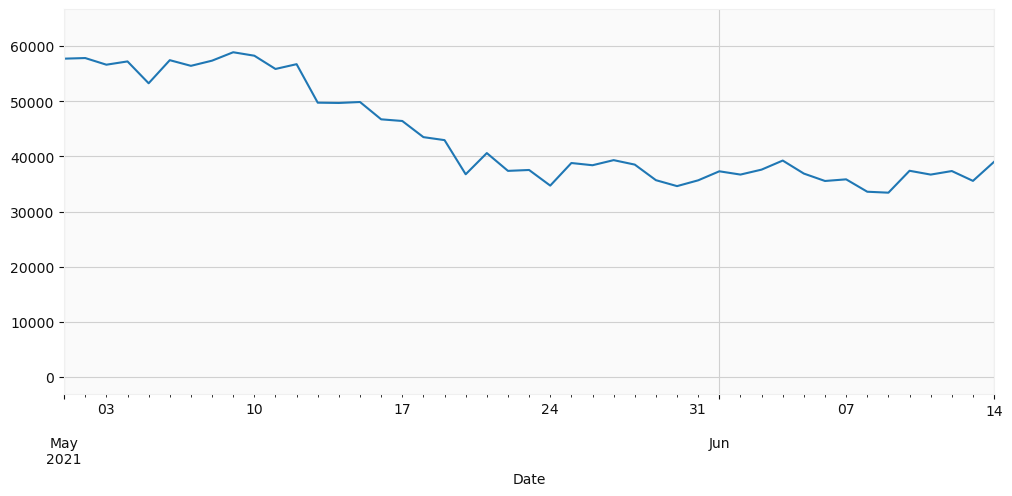

In [8]:
# initialise scraper with time interval
scraper = CmcScraper("BTC")

# get dataframe for the data
hist_crypto = scraper.get_dataframe()
hist_crypto = pd.DataFrame(hist_crypto)
pd.to_datetime(hist_crypto["Date"])
hist_crypto.set_index("Date", inplace= True)

# ------------ Work in progress -------------
# Visualization
fig = plt.figure(figsize= (12, 5))
hist_crypto["Open"].plot()
plt.xlim("2021-05-01", "2021-06-14")

# Not in correct format - recreate using matplotlib
# mpf.plot(hist_crypto["2021-05-01":"2021-06-14"],
#      type = "candle",
#      mav = (20),
#      tight_layout = True, 
#      figratio = (20, 12), 
#      style = "yahoo")

# Linear Regression Prediction (Stocks):

Check our stock's data:

In [9]:
# Check our stock's data:
hist_stock.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-15,4.49,4.55,4.42,4.51,0,0,0
2020-06-15,4.50,4.65,4.47,4.63,410912,0,0
2020-06-15,4.62,4.77,4.57,4.71,567735,0,0
2020-06-15,4.72,4.73,4.64,4.65,443062,0,0
2020-06-15,4.66,4.71,4.64,4.69,604210,0,0


We first want to create a dataset that contains all of our close data.

We've calculated a the difference between the high and low as a percentage of the close, as well as the difference between the open to close as a percentage change

In [10]:
stockDF = hist_stock.loc[:,["Open", "High", "Low", "Close", "Volume"]]
stockDF["HL_PCT"] = (hist_stock["High"] - hist_stock["Low"]) / hist_stock["Close"] * 100
stockDF["PCT_Change"] = (hist_stock["Close"] - hist_stock["Open"]) / hist_stock["Open"] * 100

# This is the data we'll use for our analysis:
stockDF.head()

,Open,High,Low,Close,Volume,HL_PCT,PCT_Change
Date,,,,,,,
2020-06-15,4.49,4.55,4.42,4.51,0,2.882486,0.445445
2020-06-15,4.50,4.65,4.47,4.63,410912,3.887695,2.888891
2020-06-15,4.62,4.77,4.57,4.71,567735,4.246280,1.948055
2020-06-15,4.72,4.73,4.64,4.65,443062,1.935487,-1.483044
2020-06-15,4.66,4.71,4.64,4.69,604210,1.492541,0.643781


This is a bunch of preprocessing the data so it's appropriate for the sklearn model. 

This is a bit that I need to familiarize myself with more, but without it, it won't work. 

In [11]:
from sklearn import preprocessing

# Drop missing value
stockDF.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(stockDF)))

# Separating the label here, as we want to predict the Close
forecast_col = "Close"
stockDF['Label'] = stockDF[forecast_col].shift(-forecast_out)
X = np.array(stockDF.drop(['Label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(stockDF['Label'])
y = y[:-forecast_out]

We'll now import the LinearRegression model 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

from sklearn.linear_model import LinearRegression

Fitting the model is as easy as 2 lines!

In [14]:
# lm stands for "linear model"
lm = LinearRegression(n_jobs=-1)
lm.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

Creating our forecasting data:

In [15]:
forecast_set = lm.predict(X_lately)
stockDF['Forecast'] = np.nan

Plotting it out:

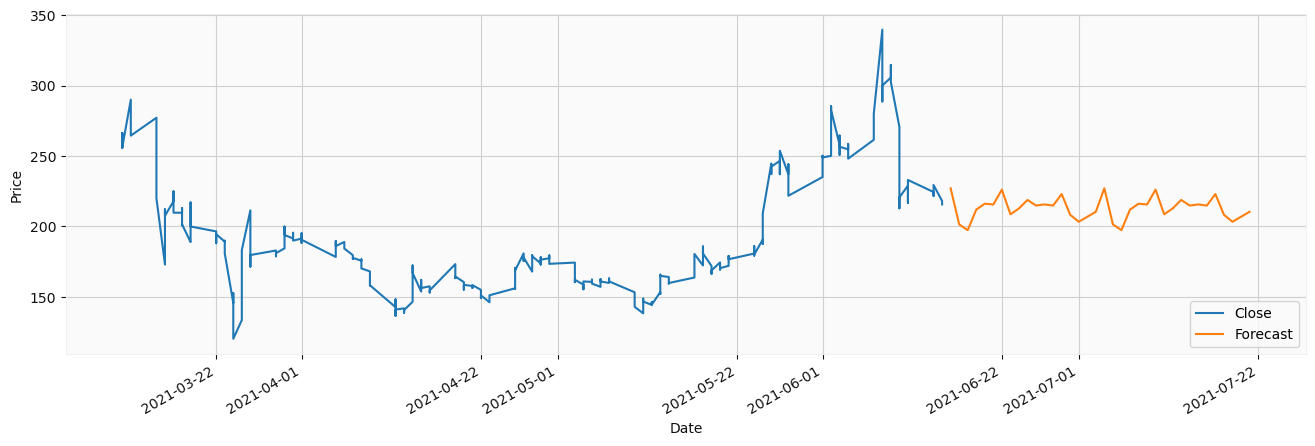

In [19]:
# Creating a bigger plot size:
fig = plt.figure(figsize= (16, 5))

# Date conversions:
last_date = stockDF.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

# This section I had to ask StackOverflow....
for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    stockDF.loc[next_date] = [np.nan for _ in range(len(stockDF.columns)-1)]+[i]
stockDF['Close'].tail(500).plot()
stockDF['Forecast'].tail(500).plot()

# Final plot formatting: 
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Linear Regression Prediction (Crypto):

In [17]:
hist_crypto.head()

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2021-06-14,39016.970178,40978.364477,38757.284122,40536.068967,4.851313e+10,7.594427e+11
2021-06-13,35555.790140,39322.780212,34864.109940,39097.860897,4.066911e+10,7.324657e+11
2021-06-12,37340.142844,37408.925595,34728.190101,35552.517148,3.792423e+10,6.660182e+11
2021-06-11,36697.031293,37608.694293,36044.449911,37334.399526,3.869974e+10,6.993687e+11
2021-06-10,37389.515651,38334.325443,35847.593641,36702.599375,4.357603e+10,6.875094e+11


In [20]:
cryptoDF = hist_crypto.loc[:,["Open", "High", "Low", "Close", "Volume"]]
cryptoDF["HL_PCT"] = (hist_crypto["High"] - hist_crypto["Low"]) / hist_crypto["Close"] * 100
cryptoDF["PCT_Change"] = (hist_crypto["Close"] - hist_crypto["Open"]) / hist_crypto["Open"] * 100

cryptoDF.head()

,Open,High,Low,Close,Volume,HL_PCT,PCT_Change
Date,,,,,,,
2021-06-14,39016.970178,40978.364477,38757.284122,40536.068967,4.851313e+10,5.479269,3.893431
2021-06-13,35555.790140,39322.780212,34864.109940,39097.860897,4.066911e+10,11.403873,9.962008
2021-06-12,37340.142844,37408.925595,34728.190101,35552.517148,3.792423e+10,7.540213,-4.787410
2021-06-11,36697.031293,37608.694293,36044.449911,37334.399526,3.869974e+10,4.189821,1.736839
2021-06-10,37389.515651,38334.325443,35847.593641,36702.599375,4.357603e+10,6.775356,-1.837190


In [21]:
from sklearn import preprocessing

# Drop missing value
cryptoDF.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(cryptoDF)))

# Separating the label here, as we want to predict the Close
forecast_col = "Close"
cryptoDF['Label'] = cryptoDF[forecast_col].shift(-forecast_out)
X = np.array(cryptoDF.drop(['Label'], 1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(cryptoDF['Label'])
y = y[:-forecast_out]

C:\Users\Danny\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

from sklearn.linear_model import LinearRegression

In [23]:
lm = LinearRegression(n_jobs=-1)
lm.fit(X_train, y_train)

LinearRegression(n_jobs=-1)

In [24]:
forecast_set = lm.predict(X_lately)
stockDF['Forecast'] = np.nan

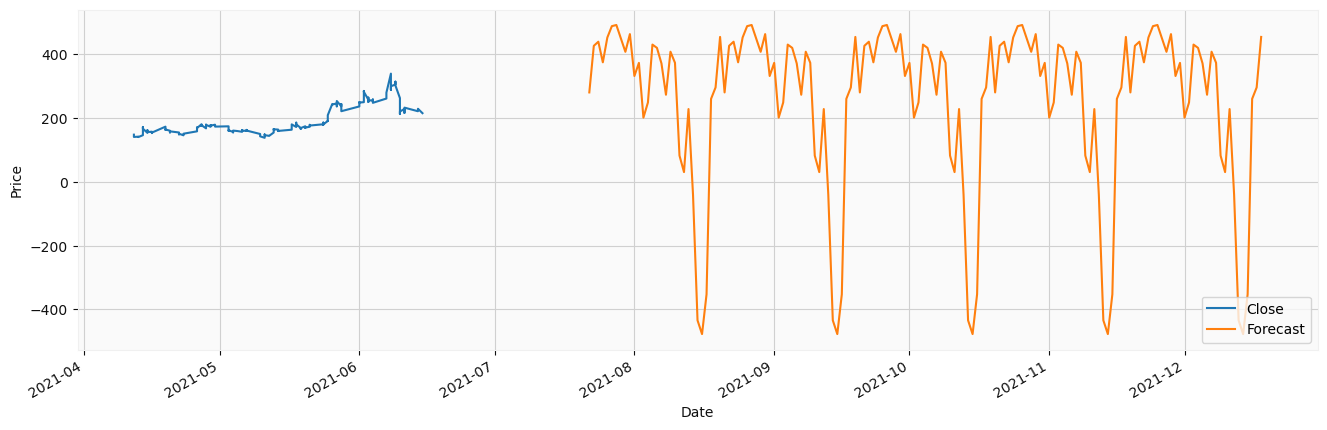

In [29]:
fig = plt.figure(figsize= (16, 5))

last_date = stockDF.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    stockDF.loc[next_date] = [np.nan for _ in range(len(stockDF.columns)-1)]+[i]
stockDF['Close'].tail(500).plot()
stockDF['Forecast'].tail(500).plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

------------------------ Work in progress - big seasonality problem ---------------------